In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

In [2]:
# Consider adding different features to the data? Tailored for HITANDRUN?
# Tinker with the 'C' parameter in SVM

In [3]:
X = pd.read_csv('Data/Analysis2/Crash_X2_prepared.csv')
# deleting the dummie columns that double up
X = X.drop(['DRIVER1SEX_F', 'EMRGVEH_No', 'D1COND_Fatigue / Sick', 'MOTORCYCLE_No', 'CRASHSEVER_Property Damage Only' ], axis=1)
y = pd.read_csv('Data/Analysis2/Crash_y2.csv')

In [4]:
'''# If you run this, it changes y to be hitandruns
X = pd.concat((X, pd.DataFrame(y)), axis=1)
X = X.rename(index=str, columns={"0": "D1DRINKIN"})
y = X['HITANDRUN_Yes']
X = X.drop(['HITANDRUN_Yes'], axis=1)'''

'# If you run this, it changes y to be hitandruns\nX = pd.concat((X, pd.DataFrame(y)), axis=1)\nX = X.rename(index=str, columns={"0": "D1DRINKIN"})\ny = X[\'HITANDRUN_Yes\']\nX = X.drop([\'HITANDRUN_Yes\'], axis=1)'

In [177]:
# Class weights
n_samples = len(X)
n_classes = 2
class_weights = n_samples / (n_classes * np.bincount(y))
print('class weight for 0 is:', class_weights[0])
print('class weight for 1 is:', class_weights[1])

class weight for 0 is: 0.568637000061
class weight for 1 is: 4.14235033259


In [182]:
np.bincount(y)

array([57308, 15669])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

* Since very unbalanced, [this stack exchange](https://stats.stackexchange.com/questions/94295/svm-for-unbalanced-data) should help
* Looks like [this](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html), using [Stochastic Gradient Descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) is our scikit learn option
* Here's [Scikit Learn's full SVM Documentation and explanations](http://scikit-learn.org/stable/modules/svm.html)

In [5]:
# Fit the SVM model
# This appears to be my best model!
clf = SVC(kernel='linear')
clf.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
clf.coef_

array([[ -6.29920955e-05,  -2.55673019e-05,   5.47977257e-05,
         -3.67141563e-05,   2.43862441e-05,   5.19146302e-05,
         -8.16505670e-04,   9.07554341e-05,   1.17477975e-05,
          1.99982838e+00,  -1.67895171e-04,   1.94747806e-04,
         -1.94747803e-04,   5.04960751e-06,   1.07416327e-04,
          3.72678038e-04]])

* Here are [metric options](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba) for unbalanced classification problems like this one According to that article, precision is the best metric in our case.

In [8]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.99      0.92     18944
          1       0.89      0.42      0.57      5139

avg / total       0.87      0.86      0.84     24083



In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)

True negatives: 18679
True positives: 2136
False negatives: 3003
False Positives: 265


In [10]:
confusion_matrix(y_test, y_pred)

array([[18679,   265],
       [ 3003,  2136]])

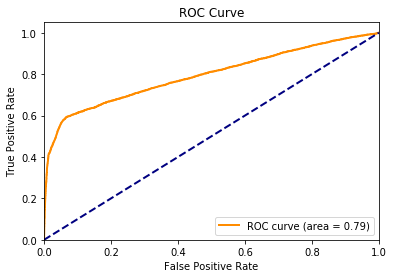

In [11]:
y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Cross-Validation

In [59]:
clf = SVC(kernel='linear')
cv_results = cross_validate(clf, X, y.values.ravel(), return_train_score=False, cv=5, scoring = ['precision', 'recall', 'roc_auc'])

In [60]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_precision', 'test_recall', 'test_roc_auc'])

In [61]:
print('Using cross-validation:')
for i in cv_results.keys():
    print('The', i, 'was:', cv_results[i])

Using cross-validation:
The fit_time was: [ 45.39114285  45.61735773  50.71426201  44.16301799  49.56031179]
The score_time was: [ 16.58702612  13.40687537  13.37206793  13.13113308  14.74525309]
The test_precision was: [ 0.90909091  0.90755735  0.88997214  0.87054161  0.86648685]
The test_recall was: [ 0.4275686   0.42916401  0.40778558  0.42054882  0.41015002]
The test_roc_auc was: [ 0.80989573  0.7989994   0.79821036  0.79120528  0.78035172]


In [120]:
clf = SVC(kernel='linear')
params = {'C': 1}
cv_clf = GridSearchCV(estimator = clf, param_grid = params, cv=5, scoring = 'precision')

In [121]:
cv_clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e+01,   1.00000e+00,   1.00000e-01,   1.00000e-02,
         1.00000e-03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [123]:
y_pred = cv_clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.99      0.92     18944
          1       0.89      0.42      0.57      5139

avg / total       0.87      0.86      0.84     24083



In [124]:
confusion_matrix(y_test, y_pred)

array([[18679,   265],
       [ 3003,  2136]])

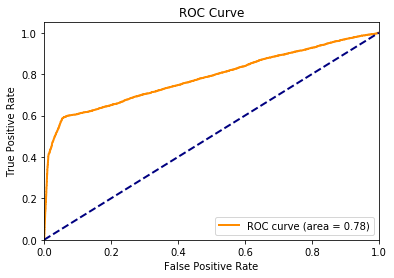

In [125]:
y_score = cv_clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---

In [16]:
# fit the model and get the separating hyperplane using weighted classes
wclf = SVC(kernel='linear', class_weight='balanced')
wclf.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
y_pred = wclf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[17020,  1868],
       [ 1859,  3336]])

In [18]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.90      0.90     18888
          1       0.64      0.64      0.64      5195

avg / total       0.85      0.85      0.85     24083



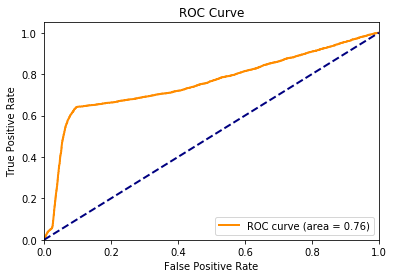

In [19]:
y_score = wclf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---

In [30]:
clf = LogisticRegression(C=.1)
clf.fit(X_train, y_train.values.ravel())

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.97      0.92     18888
          1       0.82      0.51      0.63      5195

avg / total       0.87      0.87      0.86     24083



In [32]:
confusion_matrix(y_test, y_pred)
# Diagonals are correct
# Top right is false positives
# Bottom left is false negatives

array([[18311,   577],
       [ 2546,  2649]])

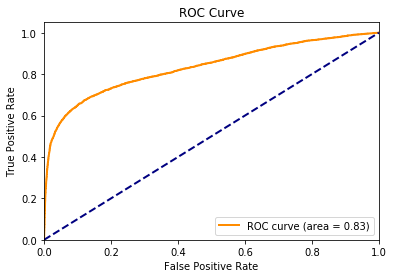

In [33]:
y_score = clf.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---

In [4]:
from sklearn import tree
import graphviz

In [7]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=5)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=5, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

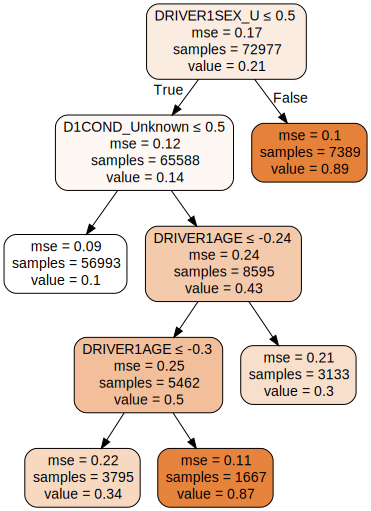

In [8]:
dot_data = tree.export_graphviz(regr, out_file=None, 
                         feature_names=X.columns, 
                         filled=True, rounded=True,  
                         special_characters=True,
                               precision=2)
tree_viz = graphviz.Source(dot_data)
tree_viz